**[SNE-01]** 모듈을 임포트하고 난수의 시드를 설정한다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

%matplotlib inline
np.random.seed(20160614)
tf.set_random_seed(20160614)

**[SNE-02]** 트레이닝 세트 데이터를 생성한다.

In [2]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df

df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

**[SNE-03]** (x1, x2)와 t를 각각 모은 것을 NumPy의 array 오브젝트로 추출해둔다.

In [3]:
train_x = train_set[['x1','x2']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])

**[SNE-04]** 단층 신경망을 이용한 이항 분류기 모델을 정의한다.

In [4]:
num_units = 2 # 수정해볼 부분
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

**[SNE-05]** 오차 함수 loss, 트레이닝 알고리즘 train_step, 정답률 accuracy를 정의한다.

In [5]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss) #수정해볼 부분
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[SNE-06]** 세션을 준비하고 Variable을 초기화한다.

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

**[SNE-07]** 파라미터 최적화를 1000회 반복한다.

In [7]:
i = 0
for _ in range(1000): # 수정해볼 부분
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 100, Loss: 44.921852, Accuracy: 0.430769
Step: 200, Loss: 39.270329, Accuracy: 0.676923
Step: 300, Loss: 51.999744, Accuracy: 0.584615
Step: 400, Loss: 21.708649, Accuracy: 0.907692
Step: 500, Loss: 12.736011, Accuracy: 0.953846
Step: 600, Loss: 11.937756, Accuracy: 0.953846
Step: 700, Loss: 11.448430, Accuracy: 0.953846
Step: 800, Loss: 10.916247, Accuracy: 0.953846
Step: 900, Loss: 10.570632, Accuracy: 0.953846
Step: 1000, Loss: 10.580119, Accuracy: 0.953846


**[SNE-08]** 얻어진 확률을 색의 농담으로 그림에 표시한다.

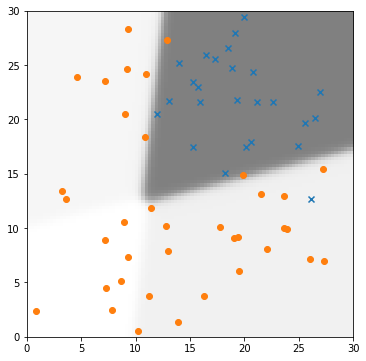

In [8]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)

In [9]:
sess.close()